<a href="https://colab.research.google.com/github/Duffany/Datacamp-project/blob/Datacamp-project/Prediction_of_direction_of_Bitcoin_based_on_sentiment_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss, roc_curve, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

### **Load Data**

In [3]:
filename_x = '/content/input_training_IrTAw7w.csv'
filename_y = '/content/output_training_F2dZW38.csv'

df = pd.read_csv(filename_x).iloc[:, 1:]
Y = pd.read_csv(filename_y).iloc[:, 1:]

Y = np.argmax(np.array(Y), axis=1)

### **Feature Engineering**

In [4]:
def transform(df):

    sentiment = get_mean_max_min_median_sentiment(df)
    # Concatenate X1-X5 with sentiment feature
    df = pd.concat([df.loc[:, 'X1':"X5"], sentiment], axis=1)
    return df
    
def get_mean_max_min_median_sentiment(df):
    
    output = pd.DataFrame()
    sentiment = df.loc[:, 'I1_lag0':'I10_lag47']
    for i in tqdm(range(1, 11)):
        col_name = "I{}".format(str(i))
        start, end = col_name + "_lag0", col_name + "_lag47"
        theme_data = sentiment.loc[:, start:end]
        output[col_name+"_max"] = theme_data.max(axis=1)
        output[col_name+"_min"] = theme_data.min(axis=1)
        output[col_name+"_mean"] = theme_data.mean(axis=1)
        output[col_name+"_median"] = theme_data.median(axis=1)
    
    return output

In [6]:
# split data into trainning data and validation data
x_train, x_valid, y_train, y_valid = train_test_split(transform(df), Y,  
                                                      test_size=0.2)

#loading test data
test_filename = '/content/input_test_PkjtqdQ.csv'
df_test = pd.read_csv(test_filename).iloc[:, 1:]
test = transform(df_test)

100%|██████████| 10/10 [00:00<00:00, 101.99it/s]


### **Use only X1 - X5 to train a simple logistic regression - Benchmark**

In [8]:
# remove history sentiment data
train = df.loc[:, 'X1':"X5"]
x_train, x_valid, y_train, y_valid = train_test_split(train, Y,  
                                                      test_size=0.2)

parameter_grid = {"C":[0.6, 0.7, 0.8, 0.9, 1]}
simple_model = GridSearchCV(LogisticRegression(), param_grid=parameter_grid,
                            n_jobs=-1)
simple_model.fit(x_train, y_train)


print(classification_report(y_valid, simple_model.predict(x_valid)))
print("The accuracy on the validation set is : {:.2f}".format(accuracy_score(y_valid, simple_model.predict(x_valid))))

              precision    recall  f1-score   support

           0       0.34      0.24      0.28       892
           1       0.35      0.39      0.37       983
           2       0.39      0.46      0.42       925

    accuracy                           0.36      2800
   macro avg       0.36      0.36      0.36      2800
weighted avg       0.36      0.36      0.36      2800

The accuracy on the validation set is : 0.36


### **Use all the sentiment data to train a regression model with L1 regularization**

In [9]:
# get all history sentiment data
train = df.loc[:, 'I1_lag0':'I10_lag47']
x_train, x_valid, y_train, y_valid = train_test_split(train, Y, test_size=0.2)


parameter_grid = {"alpha":[1e-2, 3e-2, 1e-1, 3e-1, 1]}
simple_model = GridSearchCV(SGDClassifier(penalty='l1', loss='log'), 
                            param_grid=parameter_grid,
                            n_jobs=-1)
simple_model.fit(x_train, y_train)


print(classification_report(y_valid, simple_model.predict(x_valid)))
print("The accuracy on the validation set is : {:.2f}".format(accuracy_score(y_valid, simple_model.predict(x_valid))))

              precision    recall  f1-score   support

           0       0.42      0.14      0.21       901
           1       0.36      0.68      0.47       951
           2       0.37      0.27      0.31       948

    accuracy                           0.37      2800
   macro avg       0.38      0.36      0.33      2800
weighted avg       0.38      0.37      0.33      2800

The accuracy on the validation set is : 0.37


### **Use X1-X5 and max, min, median, mean of sentiment data to train Logistic Regression (Score = 1.048)**

In [11]:
train = transform(df)
x_train, x_valid, y_train, y_valid = train_test_split(train, Y, test_size=0.2)
parameter_grid = {"C":[0.6, 0.7, 0.8, 0.9, 1]}
regression = GridSearchCV(LogisticRegression(), param_grid=parameter_grid,
                            n_jobs=-1)
regression.fit(x_train, y_train)


print(classification_report(y_valid, regression.predict(x_valid)))
print("The accuracy on the validation set is : {:.2f}".format(accuracy_score(y_valid, regression.predict(x_valid))))
print("The loss on the validation set is : {:.2f}".format(log_loss(y_valid, regression.predict_proba(x_valid))))

100%|██████████| 10/10 [00:00<00:00, 43.64it/s]


              precision    recall  f1-score   support

           0       0.45      0.27      0.34       924
           1       0.48      0.71      0.57       935
           2       0.46      0.41      0.43       941

    accuracy                           0.46      2800
   macro avg       0.46      0.46      0.45      2800
weighted avg       0.46      0.46      0.45      2800

The accuracy on the validation set is : 0.46
The loss on the validation set is : 1.03


Text(0, 0.5, 'true positive rate')

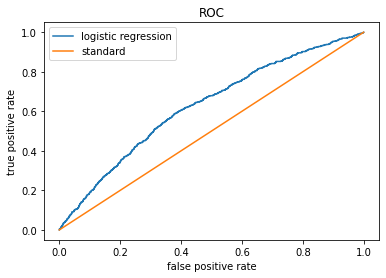

In [12]:
y_pred = regression.predict_proba(x_valid)
y_pred_up_prod = y_pred[:, 2]

y_true = (y_valid == 2).astype(int)

fpr_lr, tpr_lr, threshold = roc_curve(y_true, y_pred_up_prod)

plt.plot(fpr_lr, tpr_lr, label='logistic regression')
plt.plot((0, 1), (0, 1), label='standard')
plt.legend()
plt.title("ROC")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

In [14]:
# Predict probability of test data
output = regression.predict_proba(test)
output = pd.DataFrame(output, columns=['Target -1', 'Target 0', 'Target 1'])
output.to_csv("/content/reg_all.csv")

In [15]:
output.head()

,Target -1,Target 0,Target 1
0,0.223330,0.519877,0.256793
1,0.250567,0.468179,0.281254
2,0.258569,0.456838,0.284593
3,0.269996,0.487020,0.242984
4,0.203969,0.516161,0.279870


### **Use X1-X5, max, min, median, mean of sentiment data to train random forest (Score = 1.044)**

In [13]:
train = transform(df)
x_train, x_valid, y_train, y_valid = train_test_split(train, Y, test_size=0.2)

parameter_grid = {"max_depth":[4, 8, 16, 20], "min_samples_leaf":[4,32,64,128]}
simple_model = GridSearchCV(RandomForestClassifier(n_estimators=200), 
                            param_grid=parameter_grid,
                            n_jobs=-1, cv=5)
simple_model.fit(x_train, y_train)


print(simple_model.best_params_)
print(classification_report(y_valid, simple_model.predict(x_valid)))
print("The accuracy on the validation set is : {:.2f}".format(accuracy_score(y_valid, simple_model.predict(x_valid))))
print("The loss on the validation set is : {:.2f}".format(log_loss(y_valid, simple_model.predict_proba(x_valid))))

100%|██████████| 10/10 [00:00<00:00, 44.50it/s]


{'max_depth': 8, 'min_samples_leaf': 32}
              precision    recall  f1-score   support

           0       0.40      0.22      0.29       915
           1       0.49      0.66      0.56       953
           2       0.41      0.44      0.42       932

    accuracy                           0.45      2800
   macro avg       0.43      0.44      0.42      2800
weighted avg       0.43      0.45      0.43      2800

The accuracy on the validation set is : 0.45
The loss on the validation set is : 1.03


Text(0, 0.5, 'true positive rate')

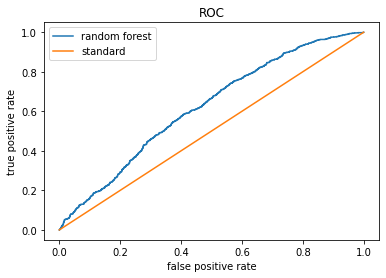

In [16]:
y_pred = simple_model.predict_proba(x_valid)
y_pred_up_prod = y_pred[:, 2]

y_true = (y_valid == 2).astype(int)

fpr_rf, tpr_rf, threshold = roc_curve(y_true, y_pred_up_prod)

plt.plot(fpr_rf, tpr_rf, label='random forest')
plt.plot((0, 1), (0, 1), label='standard')
plt.legend()
plt.title("ROC")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")


In [17]:
feature_importance = simple_model.best_estimator_.feature_importances_
feature_importance = pd.Series(feature_importance, x_train.columns)
feature_importance.sort_values().tail(20)

I2_max       0.019673
X4           0.019776
X2           0.019829
I7_median    0.021021
I5_min       0.021110
I3_min       0.021116
I3_max       0.022047
I4_max       0.023121
I4_min       0.026793
X1           0.030863
I8_min       0.034031
I7_min       0.034604
I1_min       0.036065
I6_max       0.040403
I1_max       0.042430
I10_min      0.053126
I9_min       0.053842
I10_max      0.068018
I7_max       0.079819
I9_max       0.092657
dtype: float64

In [18]:
# Predict probability of test data
output = simple_model.predict_proba(test)
output = pd.DataFrame(output, columns=['Target -1', 'Target 0', 'Target 1'])
output.to_csv("/content/sub.csv")

In [19]:
output.head()

,Target -1,Target 0,Target 1
0,0.234832,0.492358,0.272810
1,0.296338,0.414266,0.289396
2,0.273591,0.444620,0.281789
3,0.260060,0.528017,0.211924
4,0.156013,0.723544,0.120443


### **Select features then train again a Random Forest**

In [21]:
selected_features = feature_importance.sort_values().tail(20).index

train_selected = train[selected_features]

x_train_selected, x_valid_selected, y_train, y_valid = train_test_split(train_selected, Y, test_size=0.2)


parameter_grid = {"max_depth":[2, 4, 8, 16, 20], "min_samples_leaf":[16,32,64]}
decision_tree = GridSearchCV(RandomForestClassifier(n_estimators=200), 
                            param_grid=parameter_grid,
                            n_jobs=-1, cv=5)
decision_tree.fit(x_train_selected, y_train)


print(decision_tree.best_params_)
print(classification_report(y_valid, decision_tree.predict(x_valid_selected)))
print("The accuracy on the validation set is : {:.2f}".format(accuracy_score(y_valid, decision_tree.predict(x_valid_selected))))
print("The loss on the validation set is : {:.2f}".format(log_loss(y_valid, decision_tree.predict_proba(x_valid_selected))))

{'max_depth': 20, 'min_samples_leaf': 64}
              precision    recall  f1-score   support

           0       0.37      0.25      0.30       881
           1       0.50      0.66      0.57       966
           2       0.44      0.42      0.43       953

    accuracy                           0.45      2800
   macro avg       0.44      0.45      0.43      2800
weighted avg       0.44      0.45      0.44      2800

The accuracy on the validation set is : 0.45
The loss on the validation set is : 1.03


Text(0, 0.5, 'true positive rate')

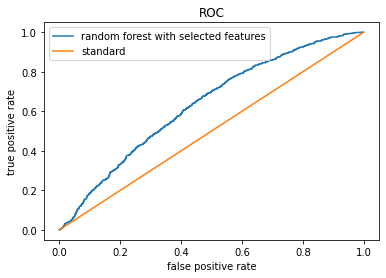

In [22]:
y_pred = decision_tree.predict_proba(x_valid_selected)
y_pred_up_prod = y_pred[:, 2]

y_true = (y_valid == 2).astype(int)

fpr_rf_sf, tpr_rf_sf, threshold = roc_curve(y_true, y_pred_up_prod)

plt.plot(fpr_rf_sf, tpr_rf_sf, label='random forest with selected features')
plt.plot((0, 1), (0, 1), label='standard')
plt.legend()
plt.title("ROC")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

In [25]:
# Predict probability of test data
test_selected = test[selected_features]
output = decision_tree.predict_proba(test_selected)
output = pd.DataFrame(output, columns=['Target -1', 'Target 0', 'Target 1'])
output.to_csv("/content/rf_sf.csv")

### **Model Comparison**

Text(0, 0.5, 'true positive rate')

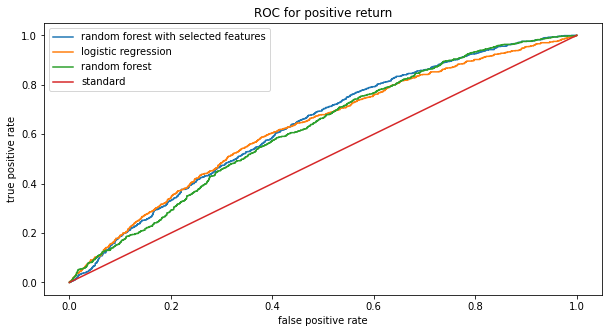

In [23]:
plt.figure(figsize=(10,5))
plt.plot(fpr_rf_sf, tpr_rf_sf, label='random forest with selected features')
plt.plot(fpr_lr, tpr_lr, label='logistic regression')
plt.plot(fpr_rf, tpr_rf, label='random forest')
plt.plot((0, 1), (0, 1), label='standard')
plt.legend()
plt.title("ROC for positive return")
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")


Text(0.5, 1.0, 'Confusion Matrix of Random Forest')

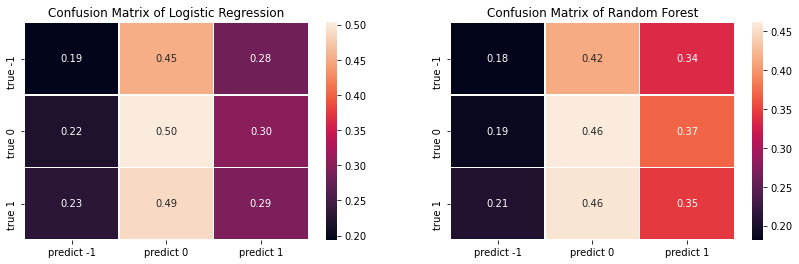

In [27]:
y_pred_lr = regression.predict(x_valid)
y_pred_rf = simple_model.predict(x_valid)

confu_mat_lr = confusion_matrix(y_valid, y_pred_lr)
confu_mat_rf = confusion_matrix(y_valid, y_pred_rf)

confu_mat_lr = confu_mat_lr/confu_mat_lr.sum(axis=1)
confu_mat_rf = confu_mat_rf/confu_mat_rf.sum(axis=1)

confu_mat_lr = pd.DataFrame(confu_mat_lr, 
                            index=['true -1', 'true 0', 'true 1'],
                           columns=['predict -1', 'predict 0', 'predict 1'])
confu_mat_rf = pd.DataFrame(confu_mat_rf, 
                            index=['true -1', 'true 0', 'true 1'],
                           columns=['predict -1', 'predict 0', 'predict 1'])


f=plt.figure(figsize=(14,4))

f.add_subplot(1,2,1)
ax = sns.heatmap(confu_mat_lr, annot=True, fmt=".2f",
           linewidth=0.5)
ax.set_title("Confusion Matrix of Logistic Regression")

f.add_subplot(1,2,2)
ax = sns.heatmap(confu_mat_rf, annot=True, fmt=".2f",
           linewidth=0.5)
ax.set_title("Confusion Matrix of Random Forest")

### **Pipeline (still in progress)**

In [28]:
from sklearn.base import TransformerMixin, BaseEstimator


def transform(df):
    
    sentiment = get_mean_max_min_median_sentiment(df)
    # Concatenate X1-X5 with sentiment feature
    df = pd.concat([df.loc[:, 'X1':"X5"], sentiment], axis=1)
    return df
    
#only trained on sentiment data
class SimpleSentimentModel(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        self.model = None
    
    def transform(self, df):
        sentiment_col_mask = df.columns.str.match("I.+")
        sentiment_col_name = df.columns[sentiment_col_mask]
        sentiment_features = df[sentiment_col_name]
        return sentiment_features
    
    def fit(self, df, y):
        sentiment_features = self.transform(df)

        parameter_grid = {"max_depth":[4, 8, 16, 20], "min_samples_leaf":[4,32,64,128]}
        self.model = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                                    param_grid=parameter_grid,
                                    n_jobs=-1)
        self.model.fit(sentiment_features, y)
        
    def predict(self, df):
        sentiment_features = self.transform(df)
        simple_sentiment_output = self.model.predict_proba(sentiment_features)
        return simple_sentiment_output
    
    def fit_predict(self, df, y):
        sentiment_features = self.transform(df)

        parameter_grid = {"max_depth":[4, 8, 16, 20], "min_samples_leaf":[4,32,64,128]}
        self.model = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                                    param_grid=parameter_grid,
                                    n_jobs=-1)
        self.model.fit(sentiment_features, y)
        return self.model.predict_proba(sentiment_features)
        
    
    
#only trained on price return data
class SimpleReturnModel(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        self.model = None
    
    def transform(self, df):
        return_col_name = df.columns[df.columns.str.match('X.+')]
        return_features = df[return_col_name]
        return return_features
    
    def fit(self, df, y):
        return_features = self.transform(df)

        parameter_grid = {"C":[0.6, 0.7, 0.8, 0.9, 1]}
        self.model = GridSearchCV(LogisticRegression(), param_grid=parameter_grid,
                                n_jobs=-1)
        self.model.fit(return_features, y)
        
    def predict(self, df):
        return_features = self.transform(df)
        simple_return_output = self.model.predict_proba(return_features)
        return simple_return_output
    
    def fit_predict(self, df, y):
        return_features = self.transform(df)

        parameter_grid = {"max_depth":[4, 8, 16, 20], "min_samples_leaf":[4,32,64,128]}
        self.model = GridSearchCV(RandomForestClassifier(n_estimators=100), 
                                    param_grid=parameter_grid,
                                    n_jobs=-1)
        self.model.fit(return_features, y)
        return self.model.predict_proba(return_features)


x_train, x_valid, y_train, y_valid = train_test_split(df, Y,  
                                                      test_size=0.3)
    
prediction_pipeline, final_lr_model = SimpleReturnModel(x_train, y_train)


y_pred =  np.argmax(prediction_pipeline(x_valid), axis=1)
print(classification_report(y_valid, y_pred))
print(accuracy_score(y_valid,y_pred))
print(log_loss(y_valid, prediction_pipeline(x_valid)))
    
    


TypeError: ignored

In [ ]:
test_filename = '/content/input_test_PkjtqdQ.csv'
test = pd.read_csv(test_filename).iloc[:, 1:]

output = prediction_pipeline(test)
output = pd.DataFrame(output, columns=['Target -1', 'Target 0', 'Target 1'])
output.to_csv("./output_data/lr_sentiment_stack_model.csv")

100%|██████████████████████████████████████████| 10/10 [00:33<00:00,  3.36s/it]
